In [155]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
%%bash 
ls .\/nameses

boy_names.txt
girl_names.txt
navn.py


In [39]:
words = open("nameses/girl_names.txt", "r").read().splitlines()
words = [word.lower() for word in words]
words[:8]

['abel', 'abelone', 'abigael', 'abigail', 'ada', 'adela', 'adelaide', 'adele']

In [40]:
len(words)

3046

In [45]:
# Building out vocabulary
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [49]:
[0] * block_size

[0, 0, 0]

In [268]:
# Building out the dataset

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [349]:
# Buliding the dataset with splits

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([16990, 3]) torch.Size([16990])
torch.Size([2119, 3]) torch.Size([2119])
torch.Size([2120, 3]) torch.Size([2120])


In [180]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([21229, 3]), torch.int64, torch.Size([21229]), torch.int64)

In [53]:
C = torch.randn((33,2))

In [55]:
C[5]

tensor([-2.5148,  1.2348])

In [64]:
# indexing is the same as one_hot matmuls -> Q.E.D
F.one_hot(torch.tensor(5), num_classes=33).float() @ C

tensor([-2.5148,  1.2348])

In [69]:
# We can use tensors and lists to index tensors (look at cells below)
C[X].shape

torch.Size([33, 3, 2])

In [70]:
X[13,2]

tensor(0)

In [71]:
C[X][13,2]

tensor([-0.8028, -1.1997])

In [72]:
C[0]

tensor([-0.8028, -1.1997])

In [73]:
# Let's create the embeddings
emb = C[X]
emb.shape

torch.Size([33, 3, 2])

In [107]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [77]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (99x2 and 6x100)

### Concatinating the embeddings of input of size (block_size)

In [90]:
# Method 1: Weak becuase changing the block size will fuck up the logic
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([33, 6])

In [89]:
# Method 2: Ok, but computationally and storage expensive
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([33, 6])

In [92]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [93]:
a.shape

torch.Size([18])

In [96]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [100]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [101]:
emb.shape

torch.Size([33, 3, 2])

In [105]:
# Method 3: Optimal as we only change our representation of the stored bytes, not the bytes themselves
torch.allclose(emb.view(33,6), torch.cat(torch.unbind(emb, 1), 1))

True

In [114]:
# Trying to calculate hidden state again
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #emb.view(emb.shape[0],6) @ W1 + b1
h.shape

torch.Size([33, 100])

In [113]:
h

tensor([[-0.9918, -0.8223, -0.8321,  ..., -0.7529,  0.9977, -0.8282],
        [-0.9548, -0.9531,  0.3691,  ...,  0.9606,  0.9970, -0.9724],
        [-0.9053, -0.8152, -0.9907,  ..., -0.9998,  0.8315, -0.9801],
        ...,
        [-0.9548, -0.9531,  0.3691,  ...,  0.9606,  0.9970, -0.9724],
        [ 0.0499,  0.2827, -0.9477,  ..., -0.9765,  0.7579, -0.8319],
        [-0.1871, -0.2498,  0.4335,  ...,  0.9866,  0.5721, -0.5995]])

In [115]:
W2 = torch.randn((100, 33))
b2 = torch.randn(33)

In [116]:
logits = h @ W2 + b2

In [117]:
logits.shape

torch.Size([33, 33])

In [118]:
logits

tensor([[-19.1274,   9.6867,   4.1302,  ...,   0.2290,   1.9382,  -5.9316],
        [  3.3393,  16.5935,   7.1666,  ...,  10.6422,   7.3879,   4.3723],
        [-13.9569,   4.2667,  -9.8416,  ...,   4.2098,  -4.6588, -11.1039],
        ...,
        [  3.3393,  16.5935,   7.1666,  ...,  10.6422,   7.3879,   4.3723],
        [-11.3697,  15.0969,   4.2187,  ...,  -3.3436,   5.2014,   0.7982],
        [ 15.7702,   4.9540,   5.3367,  ...,   4.3279,   1.5666,   4.4488]])

In [119]:
counts = logits.exp()

In [120]:
prob = counts / counts.sum(1, keepdims=True)

In [122]:
prob.shape

torch.Size([33, 33])

In [125]:
prob[:].sum()

tensor(33.)

In [128]:
prob[torch.arange(33), Y]

tensor([5.2565e-06, 4.9050e-06, 2.2710e-12, 3.3854e-04, 2.3928e-18, 5.2565e-06,
        4.9050e-06, 2.2710e-12, 3.3854e-04, 1.9766e-07, 1.3890e-05, 6.9025e-11,
        2.3602e-12, 5.2565e-06, 4.9050e-06, 7.5031e-11, 4.1883e-08, 2.0454e-05,
        2.6623e-09, 1.9434e-10, 8.6523e-12, 5.2565e-06, 4.9050e-06, 7.5031e-11,
        4.1883e-08, 2.0454e-05, 3.3433e-12, 1.1385e-04, 2.8025e-08, 5.2565e-06,
        3.3715e-05, 5.2997e-05, 1.3950e-01])

In [130]:
loss = -prob[torch.arange(33), Y].log().mean()
loss

tensor(16.4070)

## Main code

In [131]:
# ---------- Let's make this a little cleaner :) ----------

In [300]:
Xtr.shape, Ytr.shape # data

(torch.Size([17019, 3]), torch.Size([17019]))

In [350]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((33, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 33), generator=g)
b2 = torch.randn(33, generator=g)
parameters = [C, W1, b1, W2, b2]

In [351]:
sum(p.nelement() for p in parameters) # number of total parameters

13163

In [352]:
for p in parameters:
    p.requires_grad = True

In [353]:
lri = []
lossi = []
stepi = []

In [360]:
for i in range(50000):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[Xtr[ix]] # (33, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (33, 100)
    logits = h @ W2 + b2 # (33, 33)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(33), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 100**-1
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.6457486152648926


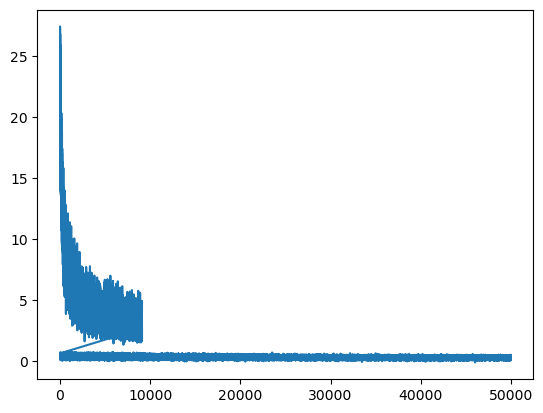

In [361]:
plt.plot(stepi, lossi)
plt.show()

In [362]:
# Estimate loss for the train set
emb = C[Xtr] # (33, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (33, 100)
logits = h @ W2 + b2 # (33, 33)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

1.6719459295272827


In [363]:
# Estimate loss for the dev set
emb = C[Xdev] # (33, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (33, 100)
logits = h @ W2 + b2 # (33, 33)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.519286632537842


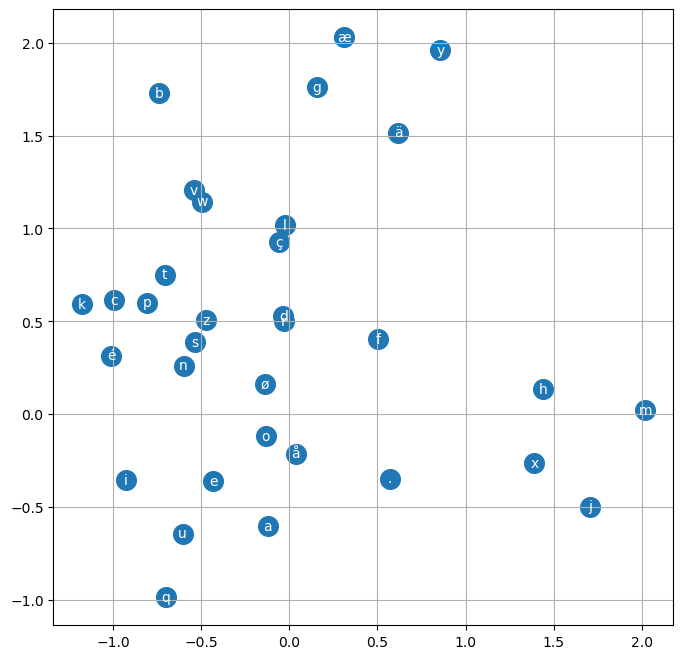

In [347]:
# plot 2-d embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")
plt.show();

## Finding the right learning rate

In [304]:
# Finding the right learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

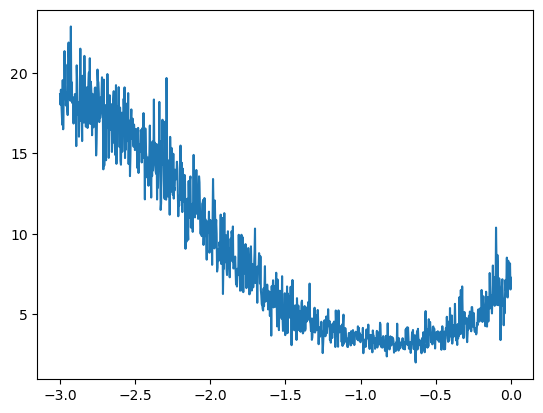

In [285]:
# Plot learning curves
plt.plot(lri, lossi)
plt.show()

## Drawing sample names 

In [366]:
g = torch.Generator().manual_seed(2147483647)  # Set the random seed for reproducibility

for i in range(10):  # Generate 5 names
    out = []
    ix = [0, 0, 0]  # Start with 3 special tokens (e.g., '.' or whatever token represents the beginning)

    while True:
        X = torch.tensor([ix])  # Create input tensor from the last 3 characters (size 1x3)

        # Forward pass through the network
        emb = C[X]  # Embed the input (shape 1x3x2 if C embeds 3 tokens into 2 dimensions)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)  # Hidden layer (flatten embedding and apply W1 and b1)
        logits = h @ W2 + b2  # Logits for the next character
        counts = logits.exp()  # Unnormalized probabilities (counts)
        p = counts / counts.sum(1, keepdims=True)  # Normalize probabilities

        # Sample the next character from the probability distribution
        ix_next = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

        # Break if end-of-sequence token (assuming 0 is the end-of-sequence token)
        if ix_next == 0:
            break

        # Convert index to character and append to output
        out.append(itos[ix_next])

        # Update the input for the next iteration (shift the input window)
        ix = ix[1:] + [ix_next]  # Slide the window, keeping the last 3 characters

    # Print the generated name
    print(''.join(out))


junida
tanca
hodania
wende
mailsine
sonf
gunn
signida
ania
victephieine


In [365]:
# Andrejs variant
g = torch.Generator().manual_seed(2147483647)  # Set the random seed for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)  # Hidden layer (flatten embedding and apply W1 and b1)
        logits = h @ W2 + b2  # Logits for the next character
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

junida.
tanca.
hodania.
wende.
mailsine.
sonf.
gunn.
signida.
ania.
victephieine.
ingerd.
jannayla.
thorbrttp.
hilde.
maja.
frøy.
marija.
lillia.
yse.
olette.
